In [14]:
# import pakages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [4]:
# get training and testing data and split them to input and output
train = pd.read_csv('sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
# get label
train_y = train['label'].values
test_y = test['label'].values

# get data
train.drop('label', axis=1, inplace=True)
train_x = train.values
test.drop('label', axis=1, inplace=True)
test_x = test.values

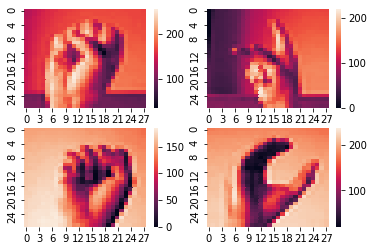

In [5]:

pixels = train_x[10].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = train_x[11].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)

pixels = train_x[20].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)

pixels = train_x[32].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)

In [6]:
def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1, dim, dim))

    return np.array(reshaped)

In [7]:
train_tensor_x = torch.FloatTensor(reshape_to_2d(train_x, 28))
train_tensor_y = torch.LongTensor(train_y.tolist())
print(train_tensor_x)

test_tensor_x = torch.FloatTensor(reshape_to_2d(test_x, 28))
test_tensor_y = torch.LongTensor(test_y.tolist())


tensor([[[[107., 118., 127.,  ..., 170., 170., 169.],
          [111., 121., 129.,  ..., 171., 171., 170.],
          [113., 123., 131.,  ..., 171., 171., 171.],
          ...,
          [142., 150., 159.,  ..., 202., 201., 200.],
          [142., 151., 160.,  ..., 204., 203., 202.],
          [142., 151., 160.,  ..., 204., 203., 202.]]],


        [[[155., 157., 156.,  ..., 138.,  92., 108.],
          [158., 159., 159.,  ..., 142., 116., 143.],
          [161., 161., 161.,  ..., 147., 125., 140.],
          ...,
          [162., 159., 145.,  ...,  91., 101.,  94.],
          [153., 139., 115.,  ...,  97.,  95., 120.],
          [135., 116.,  95.,  ..., 103., 135., 149.]]],


        [[[187., 188., 188.,  ...,  66.,  77.,  83.],
          [188., 189., 189.,  ...,  73.,  73.,  71.],
          [190., 190., 190.,  ...,  74.,  68.,  61.],
          ...,
          [212., 198., 175.,  ..., 195., 193., 192.],
          [202., 179., 152.,  ..., 195., 194., 193.],
          [198., 166., 132., 

In [8]:
epochs = 50
batch_size = 100
learning_rate = 0.001

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(20, 30, 3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(30 * 3 * 3, 270) 
        self.fc4 = nn.Linear(270, 26) 
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
                
        x = x.view(-1, 30 * 3 * 3) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
        
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)


In [20]:
net = Network()
print(net)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=270, bias=True)
  (fc4): Linear(in_features=270, out_features=26, bias=True)
  (softmax): LogSoftmax()
)


In [21]:
# adam optimizer is not working well
# optimizer = optim.Adam(net.parameters(), learning_rate)
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

In [22]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, train_tensor_x.shape[0], batch_size):
        x_mini = train_tensor_x[i:i + batch_size] 
        y_mini = train_tensor_y[i:i + batch_size] 
        
        optimizer.zero_grad()
        net_out = net(Variable(x_mini))
        
        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(test_tensor_x[:500])).data, 1)[1], test_tensor_y[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 2.899178
Epoch: 2 - Loss: 2.165111
Epoch: 3 - Loss: 1.696918
Epoch: 4 - Loss: 1.465279
Epoch: 5 - Loss: 1.132167
Epoch: 6 - Loss: 1.098037
Epoch: 7 - Loss: 1.044335
Epoch: 8 - Loss: 0.793152
Epoch: 9 - Loss: 0.722706
Epoch: 10 - Loss: 0.475048
Epoch: 11 - Loss: 0.550229
Epoch: 12 - Loss: 0.495025
Epoch: 13 - Loss: 0.516437
Epoch: 14 - Loss: 0.250287
Epoch: 15 - Loss: 0.314222
Epoch: 16 - Loss: 0.275838
Epoch: 17 - Loss: 0.340924
Epoch: 18 - Loss: 0.285595
Epoch: 19 - Loss: 0.376992
Epoch: 20 - Loss: 0.278672
Epoch: 21 - Loss: 0.245092
Epoch: 22 - Loss: 0.154512
Epoch: 23 - Loss: 0.102222
Epoch: 24 - Loss: 0.164453
Epoch: 25 - Loss: 0.155657
Epoch: 26 - Loss: 0.080681
Epoch: 27 - Loss: 0.084619
Epoch: 28 - Loss: 0.222308
Epoch: 29 - Loss: 0.045279
Epoch: 30 - Loss: 0.107561
Epoch: 31 - Loss: 0.089625
Epoch: 32 - Loss: 0.081423
Epoch: 33 - Loss: 0.105045
Epoch: 34 - Loss: 0.113066
Epoch: 35 - Loss: 0.092619
Epoch: 36 - Loss: 0.080464
Epoch: 37 - Loss: 0.129657
Epoch: 38 

In [24]:
# save model
torch.save(net, './models/SGD_model.pt')

In [21]:
# set dim
dim = 28
# mapping the alphabet
alphabets = [
  'a', 'b', 'c', 'd', 'e',
  'f', 'g', 'h', 'i', 'j',
  'k', 'l', 'm', 'n', 'o',
  'p', 'q', 'r', 's', 't',
  'u', 'v', 'w', 'x', 'y',
  'z'
]

# load model
model = torch.load('./models/SGD_model.pt')
# get one sample and check if it correct or not
randomInt = random.randint(0, len(test_y))
inputImage = np.array(test_x[randomInt]).reshape(1, dim, dim)
model_out = model(Variable(torch.FloatTensor([inputImage.tolist()])))
predict = torch.max(model_out.data, 1)[1].numpy()[0]
predict_alphabet= alphabets[predict]
actual_output = alphabets[test_y[randomInt]]

print("the pridiction is: %s", predict_alphabet)
print("the real outcome is: %s", actual_output)

the pridiction is: %s h
the real outcome is: %s h
